# 1. 분류 모델 학습 (외부 데이터 x 내부에서 사용한 데이터로 학습)

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 모델 불러오기
model_path = "Copycats/koelectra-base-v3-generalized-sentiment-analysis"
num_labels = 7

# 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels, ignore_mismatched_sizes=True)

# 2. 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.texts = dataframe['text'].astype(str).fillna('').tolist()
        self.labels = dataframe['target'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # 배치 크기 제거
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

# CSV 데이터 로드
data_path = '/data/ephemeral/home/hsk/level2-nlp-datacentric-nlp-01/data/processed_data/noise_delete.csv'
df = pd.read_csv(data_path)
dataset = CustomDataset(df, tokenizer)

# 3. Trainer 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# 학습
trainer.train()



Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Copycats/koelectra-base-v3-generalized-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
500,1.762700


TrainOutput(global_step=525, training_loss=1.7549371119907924, metrics={'train_runtime': 81.7758, 'train_samples_per_second': 102.72, 'train_steps_per_second': 6.42, 'total_flos': 552558021120000.0, 'train_loss': 1.7549371119907924, 'epoch': 3.0})

# 2. 해당 분류모델의 CLS 토큰을 활용하여 임베딩 스페이스에서 각 텍스트 시각화

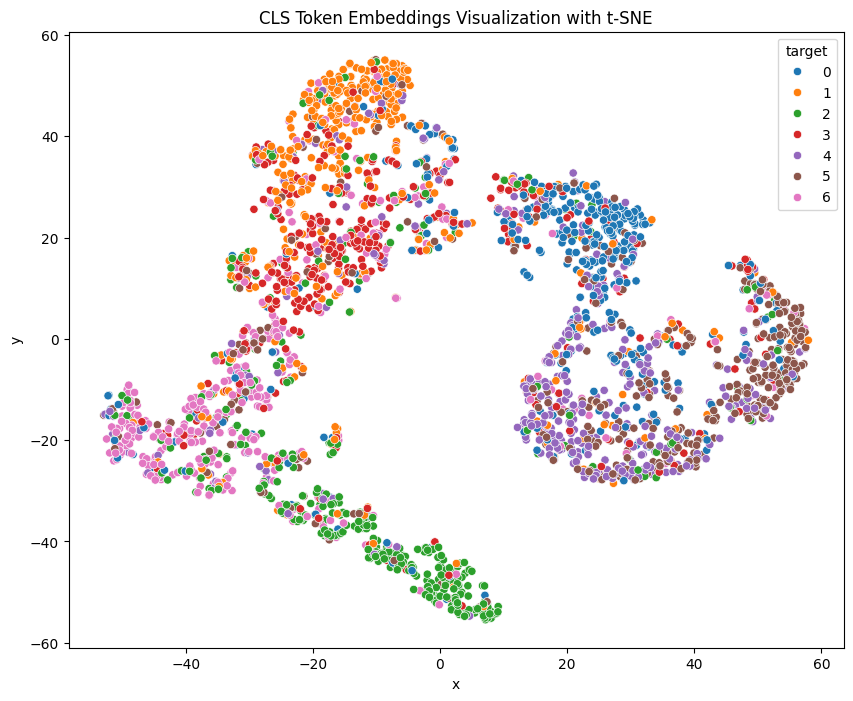

In [24]:
# 장치 설정 (GPU가 사용 가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. CLS 토큰 벡터 추출
model.eval()
cls_vectors = []
labels = []

with torch.no_grad():
    for sample in dataset:
        # 입력 텐서를 device에 올림
        input_ids = sample['input_ids'].unsqueeze(0).to(device)
        attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
        
        output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        # CLS 토큰 벡터는 마지막 히든 스테이트의 첫 번째 토큰
        cls_vector = output.hidden_states[-1][:, 0, :].squeeze().cpu().numpy()  # 벡터를 CPU로 이동하여 numpy 배열로 변환
        cls_vectors.append(cls_vector)
        labels.append(sample['labels'].item())

# 5. 차원 축소 및 시각화
cls_vectors_np = np.array(cls_vectors)  # numpy 배열로 변환
tsne = TSNE(n_components=2, random_state=42)
cls_vectors_2d = tsne.fit_transform(cls_vectors_np)

# 데이터프레임으로 변환하여 플로팅
df_plot = pd.DataFrame(cls_vectors_2d, columns=['x', 'y'])
df_plot['target'] = labels

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='x', y='y', hue='target', palette='tab10', legend='full')
plt.title("CLS Token Embeddings Visualization with t-SNE")
plt.show()


# 3. 데이터만 바꾸면서 시각화하여 군집화정도 확인

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


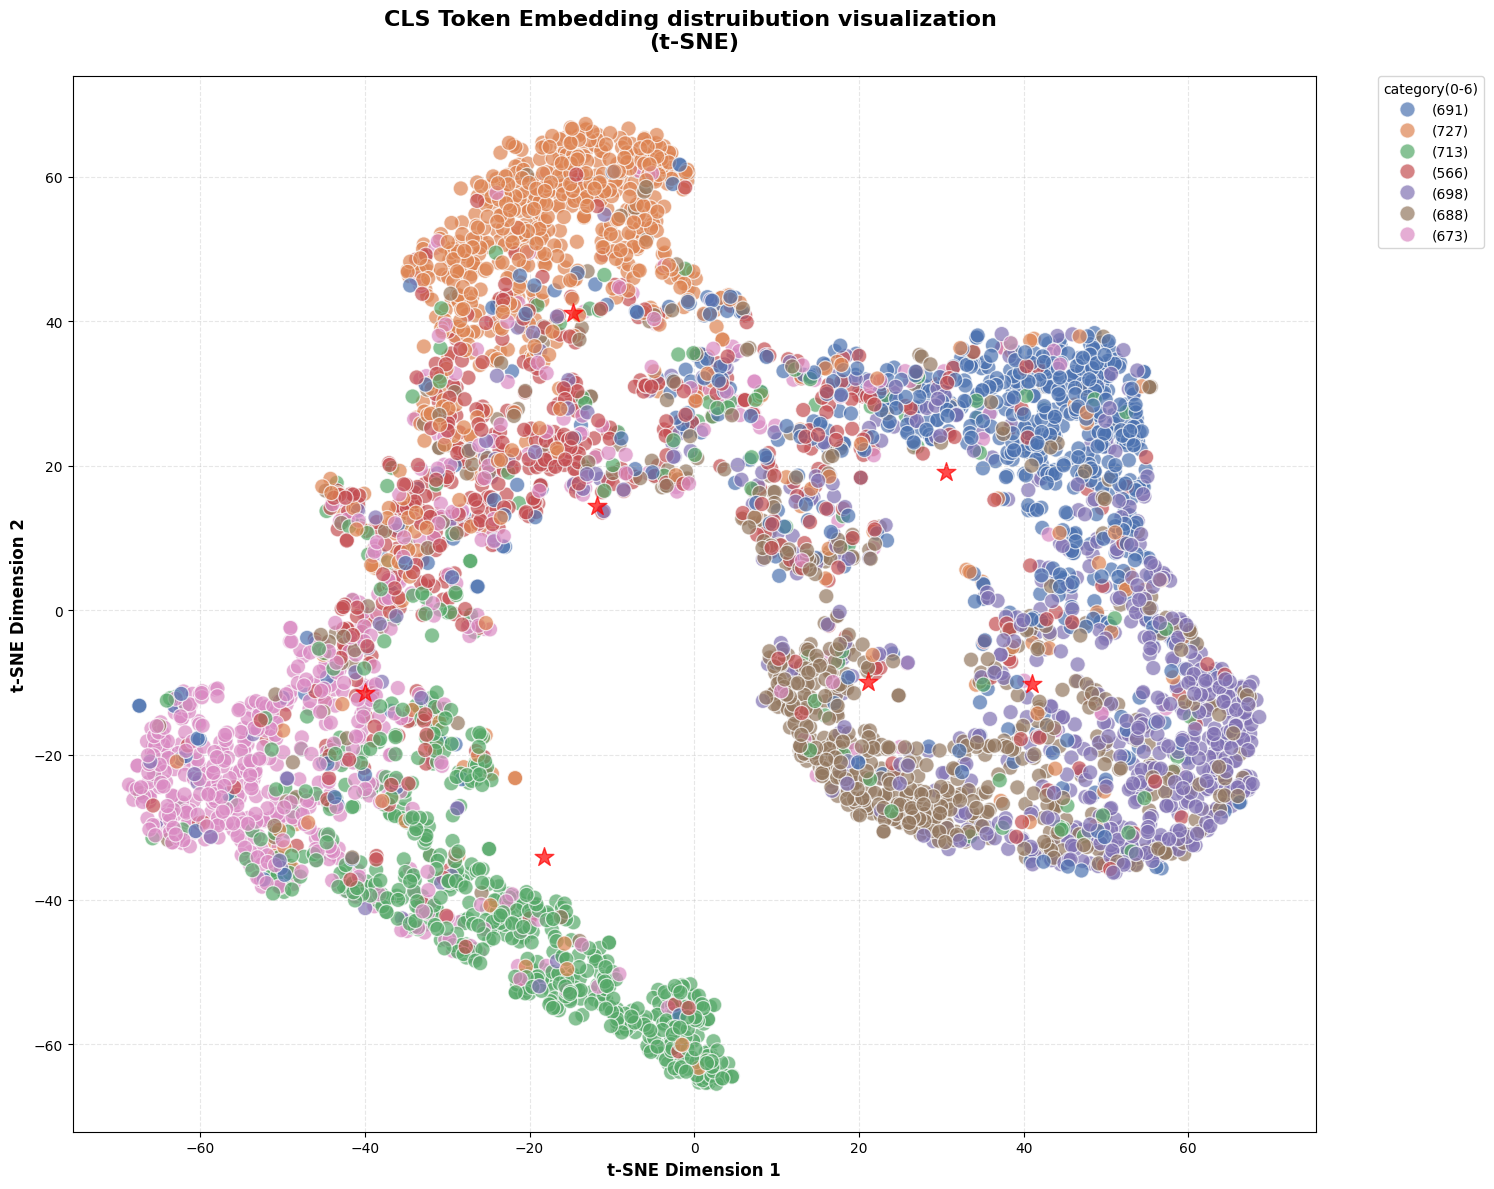

In [31]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# 데이터셋 정의 
class CustomDataset(Dataset):
   def __init__(self, dataframe, tokenizer, max_len=128):
       self.texts = dataframe['text'].astype(str).fillna('').tolist()
       self.labels = dataframe['target'].tolist()
       self.tokenizer = tokenizer
       self.max_len = max_len

   def __len__(self):
       return len(self.texts)

   def __getitem__(self, idx):
       text = self.texts[idx]
       label = self.labels[idx]
       inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
       inputs = {key: val.squeeze(0) for key, val in inputs.items()}
       inputs['labels'] = torch.tensor(label, dtype=torch.long)
       return inputs

# 시각화 함수
def visualize_clusters(data_path, model, tokenizer, device):
   # 데이터셋 로드
   df = pd.read_csv(data_path)
   dataset = CustomDataset(df, tokenizer)
   
   # CLS 토큰 벡터 추출
   model.eval()
   cls_vectors = []
   labels = []

   with torch.no_grad():
       for sample in dataset:
           input_ids = sample['input_ids'].unsqueeze(0).to(device)
           attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
           
           output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
           cls_vector = output.hidden_states[-1][:, 0, :].squeeze().cpu().numpy()
           cls_vectors.append(cls_vector)
           labels.append(sample['labels'].item())

   # t-SNE 차원 축소
   tsne = TSNE(
       n_components=2,
       random_state=42,
       perplexity=40,  # 조정된 perplexity
       n_iter=2000,    # 증가된 반복 횟수
       learning_rate='auto',
       init='pca'      # PCA 초기화 사용
   )
   cls_vectors_2d = tsne.fit_transform(np.array(cls_vectors))

   # 데이터프레임 변환
   df_plot = pd.DataFrame(cls_vectors_2d, columns=['x', 'y'])
   df_plot['target'] = labels

   # 클래스별 데이터 수 계산
   class_counts = df_plot['target'].value_counts().sort_index()
   
   # 시각화
   plt.figure(figsize=(15, 12))
   
   # 메인 산점도
   scatter = sns.scatterplot(
       data=df_plot,
       x='x',
       y='y',
       hue='target',
       palette='deep',
       s=120,  # 증가된 점 크기
       alpha=0.7,
       legend='full'
   )

   # 클래스별 중심점 계산 및 표시
   for target in df_plot['target'].unique():
       mask = df_plot['target'] == target
       center_x = df_plot[mask]['x'].mean()
       center_y = df_plot[mask]['y'].mean()
       plt.scatter(center_x, center_y, 
                  c='red', 
                  marker='*', 
                  s=200, 
                  label=f'Center {target}',
                  alpha=0.7)

   # 범례 설정
   target_names = {
       0: f"({class_counts[0]})",
       1: f"({class_counts[1]})",
       2: f"({class_counts[2]})",
       3: f"({class_counts[3]})",
       4: f"({class_counts[4]})",
       5: f"({class_counts[5]})",
       6: f"({class_counts[6]})"
   }
   
   handles, labels = scatter.get_legend_handles_labels()
   labels = [target_names.get(int(label), label) for label in labels if label.isdigit()]
   plt.legend(handles[:7], labels,
             title="category(0-6)",
             bbox_to_anchor=(1.05, 1),
             loc='upper left',
             borderaxespad=0,
             fontsize=10)

   # 축 레이블 및 제목
   plt.xlabel("t-SNE Dimension 1", fontsize=12, fontweight='bold')
   plt.ylabel("t-SNE Dimension 2", fontsize=12, fontweight='bold')
   plt.title("CLS Token Embedding distruibution visualization \n(t-SNE)", 
            pad=20, 
            fontsize=16, 
            fontweight='bold')

   # 그리드 추가
   plt.grid(True, linestyle='--', alpha=0.3)
   
   # 테두리 추가
   plt.box(True)
   
   # 레이아웃 조정
   plt.tight_layout()
   
   # 저장 및 출력
   plt.savefig('news_category_tsne_visualization.png', 
               dpi=300, 
               bbox_inches='tight',
               facecolor='white',
               edgecolor='none')
   plt.show()

# 실행
new_data_path = '/data/ephemeral/home/hsk/level2-nlp-datacentric-nlp-01/AUG_data_with_LLM_BT.csv'
visualize_clusters(new_data_path, model, tokenizer, device)